## Part I: Data Pre-processing

In [9]:
import pandas as pd

In [4]:
# Download the Google Analogy dataset
!wget http://download.tensorflow.org/data/questions-words.txt

'wget' ���O�����Υ~���R�O�B�i���檺�{���Χ妸�ɡC


In [3]:
# Preprocess the dataset
file_name = "questions-words"
with open(f"{file_name}.txt", "r") as f:
    data = f.read().splitlines()

In [4]:
# check data from the first 10 entries
for entry in data[:10]:
    print(entry)

: capital-common-countries
Athens Greece Baghdad Iraq
Athens Greece Bangkok Thailand
Athens Greece Beijing China
Athens Greece Berlin Germany
Athens Greece Bern Switzerland
Athens Greece Cairo Egypt
Athens Greece Canberra Australia
Athens Greece Hanoi Vietnam
Athens Greece Havana Cuba


In [ ]:
# TODO1: Write your code here for processing data to pd.DataFrame
# Please note that the first five mentions of ": " indicate `semantic`,
# and the remaining nine belong to the `syntatic` category.

questions = []
categories = []
sub_categories = []

current_category = None
current_sub_category = None
category_count = 0

for line in data:
    line = line.strip()
    
    
    if line.startswith(":"):        # 檢查（以":"開頭）
        current_sub_category = line
        
        # 根據計數確定是 semantic 還是 syntactic
        if category_count < 5:
            current_category = "semantic"
        else:
            current_category = "syntactic"
        
        category_count += 1
    
    # elif 不是類別標記且非空，那麼就是一個問題
    elif line and len(line.split()) == 4:  # 確保有4個詞
        # 將類比問題存為原始格式
        questions.append(line)
        categories.append(current_category)
        sub_categories.append(current_sub_category)

In [6]:
# Create the dataframe
df = pd.DataFrame(
    {
        "Question": questions,
        "Category": categories,
        "SubCategory": sub_categories,
    }
)

In [7]:
df.head()

,Question,Category,SubCategory
0,Athens Greece Baghdad Iraq,semantic,: capital-common-countries
1,Athens Greece Bangkok Thailand,semantic,: capital-common-countries
2,Athens Greece Beijing China,semantic,: capital-common-countries
3,Athens Greece Berlin Germany,semantic,: capital-common-countries
4,Athens Greece Bern Switzerland,semantic,: capital-common-countries


In [8]:
df.to_csv(f"{file_name}.csv", index=False)

## Part II: Use pre-trained word embeddings
- After finish Part I, you can run Part II code blocks only.

In [9]:
import pandas as pd
import numpy as np
import gensim.downloader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [10]:
data = pd.read_csv("questions-words.csv")

In [11]:
MODEL_NAME = "glove-wiki-gigaword-100"
# You can try other models.
# https://radimrehurek.com/gensim/models/word2vec.html#pretrained-models

# Load the pre-trained model (using GloVe vectors here)
model = gensim.downloader.load(MODEL_NAME)
print("The Gensim model loaded successfully!")

The Gensim model loaded successfully!


In [ ]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []


# TODO2: Write your code here to use pre-trained word embeddings for getting predictions of the analogy task.
# You should also preserve the gold answers during iterations for evaluations later.

""" Hints
# Unpack the analogy (e.g., "man", "woman", "king", "queen")
# Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
# Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
# Mikolov et al., 2013: big - biggest and small - smallest
# Mikolov et al., 2013: X = vector("biggest") − vector("big") + vector("small").
"""

for analogy in tqdm(data["Question"]):
    words = analogy.split()

    # （A B C D）
    if len(words) == 4:
        word_a, word_b, word_c, word_d = words
        
        # D詞
        golds.append(word_d)
        
        try:
            # 檢查所有詞是否在模型的詞彙表中 by claude
            if all(word in model.key_to_index for word in [word_a, word_b, word_c]):
                # 執行向量計算: B + C - A，找最相似的詞
                # 同時排除已用過的詞A, B, C（避免模型直接返回輸入詞）
                result = model.most_similar(
                    positive=[word_b, word_c],
                    negative=[word_a],
                    topn=1
                )
                # 取得預測結果（最相似詞彙）
                pred_word = result[0][0]
                preds.append(pred_word)
            else:
                # 如果有詞不在詞彙表中，就用空字符串作為預測結果
                preds.append("")
        except KeyError:
            # 處理可能的KeyError異常，同樣用空字符串作為預測結果
            preds.append("")

100%|██████████| 19544/19544 [01:43<00:00, 188.22it/s] 


In [13]:
# Perform evaluations. You do not need to modify this block!!

def calculate_accuracy(gold: np.ndarray, pred: np.ndarray) -> float:
    return np.mean(gold == pred)

golds_np, preds_np = np.array(golds), np.array(preds)
data = pd.read_csv("questions-words.csv")

# Evaluation: categories
for category in data["Category"].unique():
    mask = data["Category"] == category
    golds_cat, preds_cat = golds_np[mask], preds_np[mask]
    acc_cat = calculate_accuracy(golds_cat, preds_cat)
    print(f"Category: {category}, Accuracy: {acc_cat * 100}%")

# Evaluation: sub-categories
for sub_category in data["SubCategory"].unique():
    mask = data["SubCategory"] == sub_category
    golds_subcat, preds_subcat = golds_np[mask], preds_np[mask]
    acc_subcat = calculate_accuracy(golds_subcat, preds_subcat)
    print(f"Sub-Category{sub_category}, Accuracy: {acc_subcat * 100}%")

Category: semantic, Accuracy: 4.656669297553275%
Category: syntactic, Accuracy: 48.09367681498829%
Sub-Category: capital-common-countries, Accuracy: 0.0%
Sub-Category: capital-world, Accuracy: 0.0%
Sub-Category: currency, Accuracy: 0.0%
Sub-Category: city-in-state, Accuracy: 0.0%
Sub-Category: family, Accuracy: 81.62055335968378%
Sub-Category: gram1-adjective-to-adverb, Accuracy: 24.39516129032258%
Sub-Category: gram2-opposite, Accuracy: 20.073891625615765%
Sub-Category: gram3-comparative, Accuracy: 79.12912912912913%
Sub-Category: gram4-superlative, Accuracy: 54.278074866310156%
Sub-Category: gram5-present-participle, Accuracy: 69.50757575757575%
Sub-Category: gram6-nationality-adjective, Accuracy: 0.0%
Sub-Category: gram7-past-tense, Accuracy: 55.44871794871795%
Sub-Category: gram8-plural, Accuracy: 71.996996996997%
Sub-Category: gram9-plural-verbs, Accuracy: 58.39080459770115%


family類別中的唯一詞彙數量: 46
具有向量表示的詞彙數量: 46
PCA降維: 從100至45維


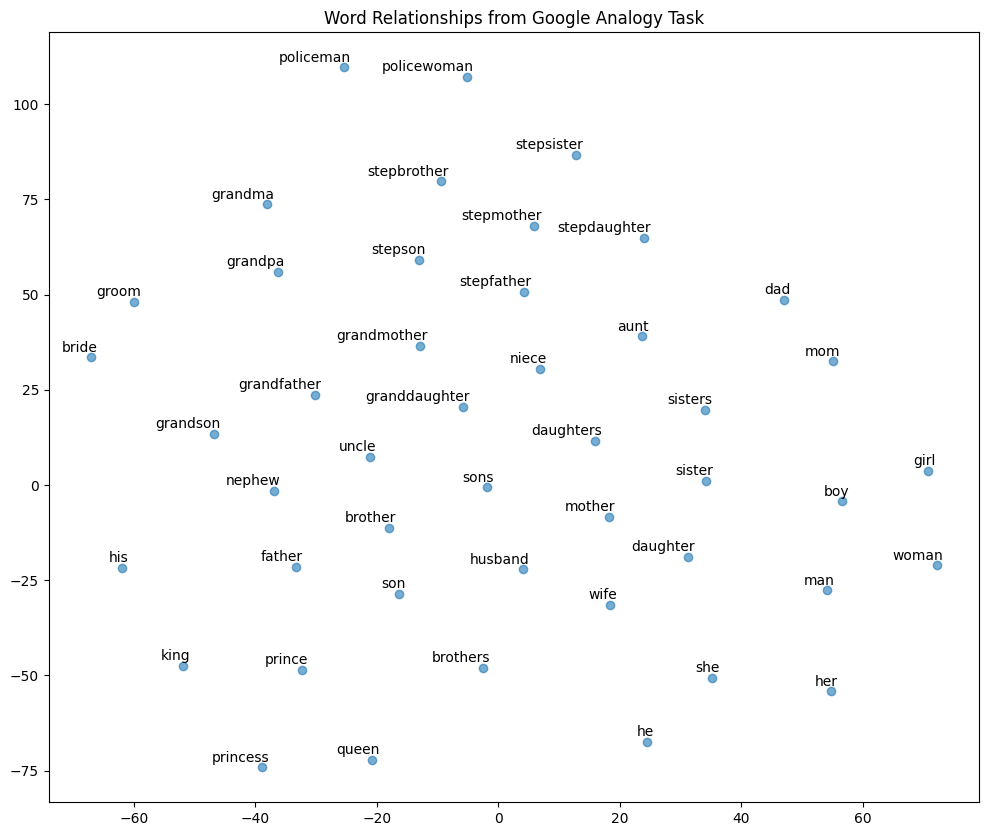

<Figure size 640x480 with 0 Axes>

In [ ]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO3: Plot t-SNE for the words in the SUB_CATEGORY `: family`
# 過濾資料 ==> Family
family_data = data[data['SubCategory'] == SUB_CATEGORY]
family_words = set()

for analogy in family_data['Question']:
    words = analogy.split()
    if len(words) == 4:
        family_words.update(words)

print(f"family類別中的唯一詞彙數量: {len(family_words)}")

family_word_vectors = []
family_word_labels = []
for word in family_words:
    if word in model.key_to_index:  # 確認詞彙存在於模型中
        family_word_vectors.append(model[word])
        family_word_labels.append(word)

print(f"具有向量表示的詞彙數量: {len(family_word_vectors)}")

family_word_vectors = np.array(family_word_vectors)
# fromclaude
# 先使用PCA降維，減少噪音並提高t-SNE的效果
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# from claude
# 使用PCA將詞向量降至50維度
pca = PCA(n_components=min(50, family_word_vectors.shape[1], family_word_vectors.shape[0]-1))
pca_result = pca.fit_transform(family_word_vectors)
print(f"PCA降維: 從{family_word_vectors.shape[1]}至{pca_result.shape[1]}維")

# form claude
# 使用t-SNE將PCA結果進一步降至2維
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
word_vectors_2d = tsne.fit_transform(pca_result)


#圖表
plt.figure(figsize=(12, 10))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.6)
for i, word in enumerate(family_word_labels): #每個點命名
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom',fontsize=10)

plt.title("Word Relationships from Google Analogy Task")
plt.show()
plt.savefig("word_relationships.png", bbox_inches="tight")

[INFO] family 類別中的唯一詞彙數量: 46
[INFO] 具有向量表示的詞彙數量: 46
[INFO] PCA: 從 100 維降至 45 維，解釋方差比例=1.00


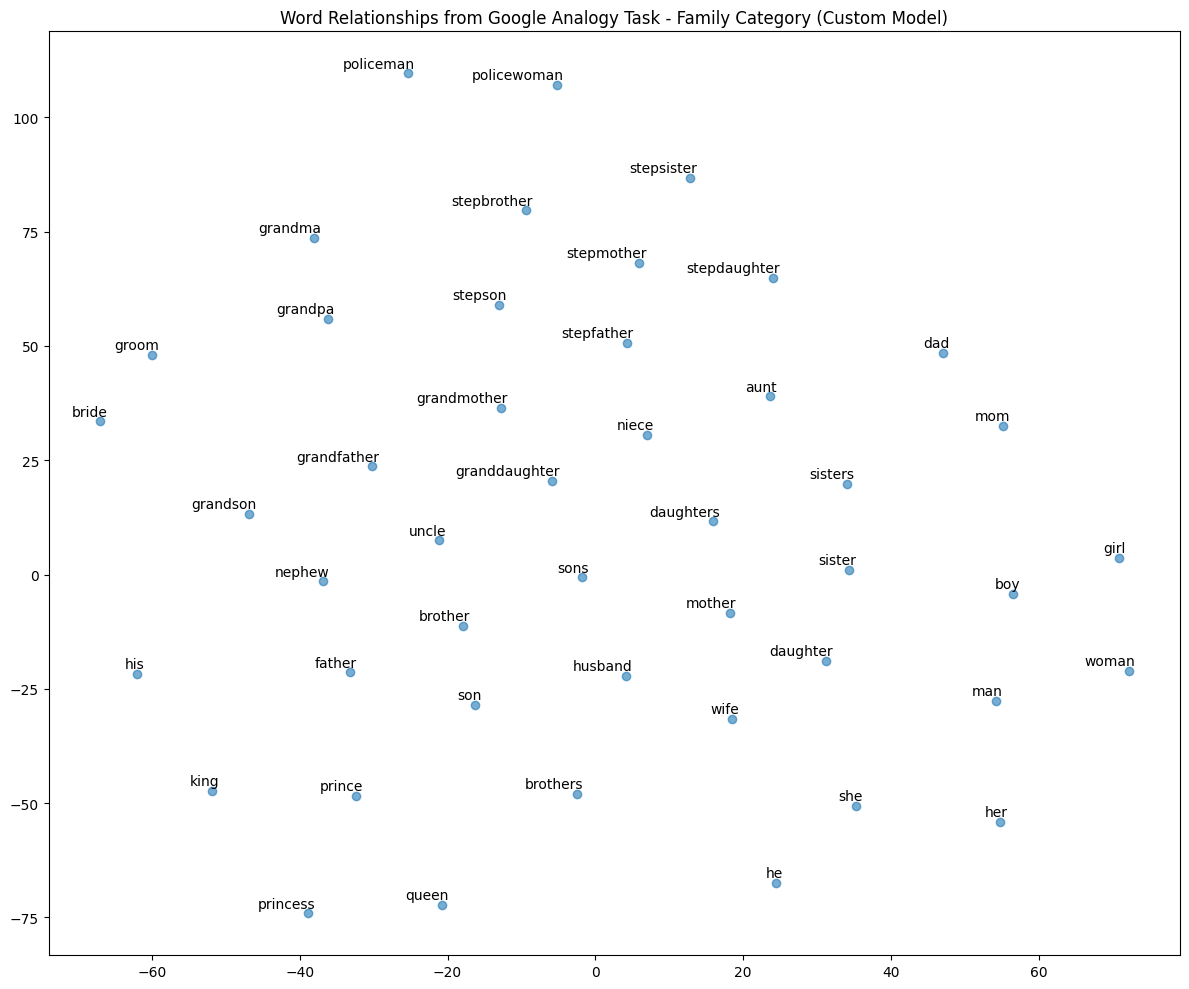

[INFO] t-SNE 圖已儲存為 word_relationships.png


In [ ]:
#From ChatGPT
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# ========== 1. 資料與參數設定 ==========

SUB_CATEGORY = ": family"
perplexity = 30
learning_rate = 200
random_seed = 42
pca_dim = 50

# 過濾出 family 子類別的資料
family_data = data[data['SubCategory'] == SUB_CATEGORY]

# 提取 family 類別中的所有唯一詞彙
family_words = set()
for analogy in family_data['Question']:
    words = analogy.split()
    if len(words) == 4:
        family_words.update(words)

print(f"[INFO] family 類別中的唯一詞彙數量: {len(family_words)}")

# ========== 2. 取得向量表示 ==========

family_word_vectors = []
family_word_labels = []

for word in family_words:
    if word in model.key_to_index:  # 確認詞彙存在於模型中
        family_word_vectors.append(model[word])
        family_word_labels.append(word)

print(f"[INFO] 具有向量表示的詞彙數量: {len(family_word_vectors)}")

# 如果沒有足夠的詞彙，就不做後續
if len(family_word_vectors) < 2:
    print("[WARN] 向量數量過少，無法進行 t-SNE 視覺化。")
else:
    family_word_vectors = np.array(family_word_vectors)

    # ========== 3. PCA 降維 (可選，但建議) ==========
    # 先將高維詞向量降到 pca_dim 維度，再用 t-SNE 降到 2 維
    # 為避免維度大於資料量，取 min(...)
    pca_dim = min(pca_dim, family_word_vectors.shape[1], family_word_vectors.shape[0] - 1)
    pca = PCA(n_components=pca_dim, random_state=random_seed)
    pca_result = pca.fit_transform(family_word_vectors)

    var_ratio = pca.explained_variance_ratio_.sum()
    print(f"[INFO] PCA: 從 {family_word_vectors.shape[1]} 維降至 {pca_dim} 維，解釋方差比例={var_ratio:.2f}")

    # ========== 4. t-SNE 降維至 2 維 ==========
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate=learning_rate,
        random_state=random_seed
    )
    word_vectors_2d = tsne.fit_transform(pca_result)

    # ========== 5. 繪圖與標籤 ==========

    fig, ax = plt.subplots(figsize=(12, 10))
    ax.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.6)

    # 為每個點添加標籤
    for i, word in enumerate(family_word_labels):
        ax.annotate(
            word,
            xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom',
            fontsize=10
        )

    ax.set_title("Word Relationships from Google Analogy Task - Family Category (Custom Model)")

    # 儲存並顯示
    plt.tight_layout()
    plt.savefig("word_relationships.png", dpi=300, bbox_inches="tight")
    plt.show()

    print("[INFO] t-SNE 圖已儲存為 word_relationships.png")

### Part III: Train your own word embeddings

### Get the latest English Wikipedia articles and do sampling.
- Usually, we start from Wikipedia dump (https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles.xml.bz2). However, the downloading step will take very long. Also, the cleaning step for the Wikipedia corpus ([`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus)) will take much time. Therefore, we provide cleaned files for you.

In [ ]:
# Download the split Wikipedia files
# Each file contain 562365 lines (articles).
!gdown --id 1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd -O wiki_texts_part_0.txt.gz
!gdown --id 1ABblLRd9HXdXvaNv8H9fFq984bhnowoG -O wiki_texts_part_1.txt.gz
!gdown --id 1z2VFNhpPvCejTP5zyejzKj5YjI_Bn42M -O wiki_texts_part_2.txt.gz
!gdown --id 1VKjded9BxADRhIoCzXy_W8uzVOTWIf0g -O wiki_texts_part_3.txt.gz
!gdown --id 16mBeG26m9LzHXdPe8UrijUIc6sHxhknz -O wiki_texts_part_4.txt.gz
!gdown --id 17JFvxOH-kc-VmvGkhG7p3iSZSpsWdgJI -O wiki_texts_part_5.txt.gz
!gdown --id 19IvB2vOJRGlrYulnTXlZECR8zT5v550P -O wiki_texts_part_6.txt.gz
!gdown --id 1sjwO8A2SDOKruv6-8NEq7pEIuQ50ygVV -O wiki_texts_part_7.txt.gz
!gdown --id 1s7xKWJmyk98Jbq6Fi1scrHy7fr_ellUX -O wiki_texts_part_8.txt.gz
!gdown --id 17eQXcrvY1cfpKelLbP2BhQKrljnFNykr -O wiki_texts_part_9.txt.gz
!gdown --id 1J5TAN6bNBiSgTIYiPwzmABvGhAF58h62 -O wiki_texts_part_10.txt.gz

D:\envAI01\Lib\site-packages\gdown\__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd
From (redirected): https://drive.google.com/uc?id=1jiu9E1NalT2Y8EIuWNa1xf2Tw1f1XuGd&confirm=t&uuid=61f4305e-dcbf-4603-97bd-8157b859b16d
To: d:\envAI01\nlp_hw1\wiki_texts_part_0.txt.gz

  0%|          | 0.00/1.51G [00:00<?, ?B/s]
  0%|          | 2.62M/1.51G [00:00<00:57, 26.2MB/s]
  0%|          | 5.24M/1.51G [00:00<02:43, 9.19MB/s]
  1%|          | 7.86M/1.51G [00:00<01:56, 12.9MB/s]
  1%|          | 10.5M/1.51G [00:00<01:35, 15.7MB/s]
  1%|          | 13.1M/1.51G [00:00<01:23, 18.0MB/s]
  1%|          | 15.7M/1.51G [00:01<01:27, 17.0MB/s]
  1%|          | 18.4M/1.51G [00:01<01:18, 19.1MB/s]
  1%|▏         | 21.0M/1.51G [00:01<01:13, 20.4MB/s]
  2%|▏         | 23.6M/1.51G [00:01<01:0

In [17]:
# Extract the downloaded wiki_texts_parts files.
# !gunzip -k wiki_texts_part_*.gz
import gzip
import shutil
import glob
import os

# 找到所有 .gz 檔案
gz_files = glob.glob("wiki_texts_part_*.txt.gz")

# 解壓每個檔案
for gz_file in gz_files:
    output_file = gz_file[:-3]  # 去掉 .gz
    if not os.path.exists(output_file):  # 如果沒解過才解壓
        with gzip.open(gz_file, 'rb') as f_in:
            with open(output_file, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Extracted: {output_file}")
    else:
        print(f"Already extracted: {output_file}")

Extracted: wiki_texts_part_0.txt
Extracted: wiki_texts_part_1.txt
Extracted: wiki_texts_part_10.txt
Extracted: wiki_texts_part_2.txt
Extracted: wiki_texts_part_3.txt
Extracted: wiki_texts_part_4.txt
Extracted: wiki_texts_part_5.txt
Extracted: wiki_texts_part_6.txt
Extracted: wiki_texts_part_7.txt
Extracted: wiki_texts_part_8.txt
Extracted: wiki_texts_part_9.txt


In [ ]:
# Combine the extracted wiki_texts_parts files.
# !cat wiki_texts_part_*.txt > wiki_texts_combined.txt
import glob
txt_files = sorted(glob.glob("wiki_texts_part_*.txt"))
with open("wiki_texts_combined.txt", "w", encoding="utf-8") as outfile:
    for fname in txt_files:
        with open(fname, "r", encoding="utf-8") as infile:
            for line in infile:
                outfile.write(line)
print("Combined into wiki_texts_combined.txt")

Combined into wiki_texts_combined.txt


In [ ]:
# Check the first ten lines of the combined file
# !head -n 10 wiki_texts_combined.txt
with open("wiki_texts_combined.txt", "r", encoding="utf-8") as f:
    for i in range(10):
        line = f.readline()
        print(f"{i+1:2d}: {line.strip()}")

 1: anarchism is political philosophy and movement that is against all forms of authority and seeks to abolish the institutions it claims maintain unnecessary coercion and hierarchy typically including the state and capitalism anarchism advocates for the replacement of the state with stateless societies and voluntary free associations as historically left wing movement this reading of anarchism is placed on the farthest left of the political spectrum usually described as the libertarian wing of the socialist movement libertarian socialism although traces of anarchist ideas are found all throughout history modern anarchism emerged from the enlightenment during the latter half of the th and the first decades of the th century the anarchist movement flourished in most parts of the world and had significant role in workers struggles for emancipation various anarchist schools of thought formed during this period anarchists have taken part in several revolutions most notably in the paris com

Please note that we used the default parameters of [`gensim.corpora.wikicorpus.WikiCorpus`](https://radimrehurek.com/gensim/corpora/wikicorpus.html#gensim.corpora.wikicorpus.WikiCorpus) for cleaning the Wiki raw file. Thus, words with one character were discarded.

In [ ]:
# Now you need to do sampling because the corpus is too big.
# You can further perform analysis with a greater sampling ratio.

# TODO4
import random

wiki_txt_path = "wiki_texts_combined.txt"
output_path = "wiki_texts_sampled.txt"
# wiki_texts_combined.txt is a text file separated by linebreaks (\n).
# Each row in wiki_texts_combined.txt indicates a Wikipedia article.
random.seed(42)
sample_ratio = 0.2  # 20%採樣率
total_lines = 0
sampled_lines = 0

print(f"開始從 {wiki_txt_path} 採樣20%的文章...")

with open(wiki_txt_path, "r", encoding="utf-8") as f:
    with open(output_path, "w", encoding="utf-8") as output_file:
    # TODO4: Sample `20%` Wikipedia articles
    # Write your code here by Claude
        for line in f:
            total_lines += 1
            # 隨機決定是否選取此行 (20%的機率)
            if random.random() < sample_ratio:
                output_file.write(line)
                sampled_lines += 1
            
            # 每處理100萬行輸出一次進度
            if total_lines % 1000000 == 0:
                print(f"已處理 {total_lines} 行，採樣 {sampled_lines} 行...")

    print(f"採樣結果已保存至 {output_path}")

開始從 wiki_texts_combined.txt 採樣20%的文章...
已處理 1000000 行，採樣 199633 行...
已處理 2000000 行，採樣 399929 行...
已處理 3000000 行，採樣 600642 行...
已處理 4000000 行，採樣 800522 行...
已處理 5000000 行，採樣 1000075 行...
採樣結果已保存至 wiki_texts_sampled.txt


In [ ]:
# TODO5 From Claude
import os
import time
import multiprocessing
import re
import logging
from collections import Counter, defaultdict
from functools import partial
import numpy as np

# Import Gensim modules
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import Word2Vec, FastText
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.phrases import Phrases, Phraser

# Import tqdm for progress bars
from tqdm.auto import tqdm

# Configure logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.WARNING)

# Create a progress callback for Word2Vec training with loss tracking
class ProgressCallback(CallbackAny2Vec):
    """Callback to show training progress and track loss for Word2Vec"""
    
    def __init__(self, total_epochs):
        self.epoch = 0
        self.total_epochs = total_epochs
        self.pbar = None
        self.previous_loss = 0
        
    def on_epoch_begin(self, model):
        if self.epoch == 0:
            self.pbar = tqdm(total=self.total_epochs, desc="訓練詞向量模型", unit="epoch")
        
    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        current_loss = loss - self.previous_loss if self.epoch > 0 else loss
        self.previous_loss = loss
        
        self.epoch += 1
        if self.pbar:
            self.pbar.update(1)
            self.pbar.set_postfix(epoch=self.epoch, loss=current_loss)
            
    def on_train_end(self, model):
        if self.pbar:
            self.pbar.close()

def remove_non_english(text):
    """Remove non-English characters but keep spaces"""
    return re.sub(r'[^a-zA-Z\s]', ' ', text)

def normalize_text(text):
    """基本文本標準化"""
    # 轉為小寫
    text = text.lower()
    # 移除多餘空白
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def improved_lemmatize(word):
    """改進版詞形還原，處理更多常見的詞尾變化"""
    if len(word) <= 2:  # 非常短的詞不處理
        return word
    
    # 簡單的詞形還原規則
    if word.endswith('ies') and len(word) > 4:
        return word[:-3] + 'y'
    elif word.endswith('es') and len(word) > 3:
        return word[:-2]
    elif word.endswith('s') and not word.endswith('ss') and not word.endswith('us') and len(word) > 3:
        return word[:-1]
    elif word.endswith('ing') and len(word) > 5:
        if len(word) > 6 and word[-4] == word[-5]:  # 雙輔音 (running -> run)
            return word[:-4]
        return word[:-3]
    elif word.endswith('ed') and len(word) > 4:
        if len(word) > 5 and word[-3] == word[-4]:  # 雙輔音 (stopped -> stop)
            return word[:-3]
        return word[:-2]
    elif word.endswith('ly') and len(word) > 4:
        return word[:-2]
    elif word.endswith('ful') and len(word) > 5:
        return word[:-3]
    elif word.endswith('ness') and len(word) > 5:
        return word[:-4]
    elif word.endswith('ment') and len(word) > 6:
        return word[:-4]
    elif word.endswith('ity') and len(word) > 5:
        return word[:-3] + 'e'
    
    return word

def preprocess_document(text, min_word_length=1, max_word_length=20, important_words=None):
    """
    改進版文本預處理，更好地處理詞彙
    """
    if important_words is None:
        important_words = {
            # 代詞
            'he', 'she', 'him', 'her', 'his', 'hers', 'they', 'them', 'their', 'theirs', 'we', 'us', 'our', 'i', 'me', 'my', 'mine',
            # 常見地名和人名
            'paris', 'france', 'italy', 'rome', 'london', 'york',
            # 常見的類比詞
            'king', 'queen', 'man', 'woman', 'boy', 'girl', 'father', 'mother', 'son', 'daughter',
            'good', 'better', 'best', 'bad', 'worse', 'worst',
            'big', 'bigger', 'biggest', 'small', 'smaller', 'smallest'
        }
    
    # 文本標準化和非英文字符移除
    text = normalize_text(remove_non_english(text))
    
    # 使用Gensim的simple_preprocess進行基本標記化
    tokens = simple_preprocess(text, min_len=1, max_len=max_word_length)  # 放寬min_len到1
    
    result = []
    for token in tokens:
        # 保留重要詞或非停用詞
        if token in important_words or (token not in STOPWORDS and len(token) >= min_word_length):
            # 對於非特殊詞，應用詞形還原
            if token not in important_words and len(token) > min_word_length:
                token = improved_lemmatize(token)
            
            # 確保詞長度在範圍內
            if len(token) >= min_word_length and len(token) <= max_word_length:
                result.append(token)
            
    return result

def process_text_chunk(chunk, min_word_length, max_word_length, important_words):
    """處理文本塊，用於多進程處理"""
    results = []
    for line in chunk:
        if line.strip():
            tokens = preprocess_document(line, min_word_length, max_word_length, important_words)
            if tokens:
                results.append(tokens)
    return results

def count_words_in_chunk(chunk):
    """統計文本塊中的詞頻，用於多進程處理"""
    counter = Counter()
    for line in chunk:
        if line.strip():
            tokens = simple_preprocess(line, min_len=1)
            counter.update(tokens)
    return counter

def process_corpus_mp(input_file, min_word_length=1, max_word_length=20, min_word_freq=2, chunk_size=10000, n_workers=None):
    """
    使用多進程處理語料庫
    """
    # 設置工作進程數
    if n_workers is None:
        n_workers = max(1, multiprocessing.cpu_count() - 1)  # 保留一個核心給系統
    
    # 增強的重要詞列表
    important_words = {
        # 代詞
        'he', 'she', 'him', 'her', 'his', 'hers', 'they', 'them', 'their', 'theirs', 'we', 'us', 'our', 'i', 'me', 'my', 'mine',
        # 常見地名和人名
        'paris', 'france', 'italy', 'rome', 'london', 'york',
        # 常見的類比詞
        'king', 'queen', 'man', 'woman', 'boy', 'girl', 'father', 'mother', 'son', 'daughter',
        'good', 'better', 'best', 'bad', 'worse', 'worst',
        'big', 'bigger', 'biggest', 'small', 'smaller', 'smallest'
    }
    
    print("讀取文件並準備分塊處理...")
    with open(input_file, 'r', encoding='utf-8') as f:
        lines = [line for line in f if line.strip()]
    
    total_lines = len(lines)
    print(f"總共讀取了 {total_lines} 行文本")
    
    # 分塊進行多進程處理
    chunks = [lines[i:i + chunk_size] for i in range(0, len(lines), chunk_size)]
    print(f"將文本分成 {len(chunks)} 個塊進行並行處理")
    
    # 首先進行詞頻統計
    print("第一階段: 詞頻統計...")
    with multiprocessing.Pool(processes=n_workers) as pool:
        chunk_counters = list(tqdm(
            pool.imap(count_words_in_chunk, chunks),
            total=len(chunks),
            desc="統計詞頻"
        ))
    
    # 合併所有計數器
    word_counter = Counter()
    for counter in chunk_counters:
        word_counter.update(counter)
    
    # 選出頻率達到閾值的詞
    print(f"詞彙頻率過濾前: {len(word_counter)} 個不同詞彙")
    frequent_words = {word for word, count in word_counter.items() if count >= min_word_freq}
    # 將重要詞添加到頻繁詞列表中，不受頻率限制
    frequent_words.update(important_words)
    print(f"詞彙頻率過濾後: {len(frequent_words)} 個不同詞彙 (出現至少{min_word_freq}次或特殊詞彙)")
    
    # 第二階段: 文本處理
    print("第二階段: 文本預處理...")
    process_func = partial(
        process_text_chunk,
        min_word_length=min_word_length,
        max_word_length=max_word_length,
        important_words=important_words
    )
    
    corpus = []
    with multiprocessing.Pool(processes=n_workers) as pool:
        results = list(tqdm(
            pool.imap(process_func, chunks),
            total=len(chunks),
            desc="並行處理文本"
        ))
        for chunk_docs in results:
            corpus.extend(chunk_docs)
    
    # 過濾語料庫，只保留高頻詞
    filtered_corpus = []
    for doc in tqdm(corpus, desc="過濾低頻詞"):
        filtered_doc = [word for word in doc if word in frequent_words or word in important_words]
        if filtered_doc:
            filtered_corpus.append(filtered_doc)
    
    # 顯示最常見的詞
    print("\n最常見的20個詞彙:")
    for word, count in word_counter.most_common(20):
        print(f"  {word}: {count}")
    
    return filtered_corpus, word_counter

def detect_phrases(corpus, min_count=5, threshold=10.0, max_vocab_size=40000000):
    """偵測文本中的常見詞組(n-grams)"""
    print("\n偵測常見詞組...")
    
    # 先建立雙詞組(bigrams)模型
    print("第一階段: 偵測雙詞組(bigrams)...")
    bigram = Phrases(
        corpus, 
        min_count=min_count, 
        threshold=threshold,
        max_vocab_size=max_vocab_size
    )
    bigram_mod = Phraser(bigram)
    
    # 應用雙詞組模型到語料庫
    corpus_bigrams = [bigram_mod[doc] for doc in tqdm(corpus, desc="應用雙詞組模型")]
    
    # 然後建立三詞組(trigrams)模型
    print("第二階段: 偵測三詞組(trigrams)...")
    trigram = Phrases(
        corpus_bigrams,
        min_count=min_count,
        threshold=threshold,
        max_vocab_size=max_vocab_size
    )
    trigram_mod = Phraser(trigram)
    
    # 應用三詞組模型
    corpus_trigrams = [trigram_mod[doc] for doc in tqdm(corpus_bigrams, desc="應用三詞組模型")]
    
    # 統計詞組數量
    phrase_counter = Counter()
    for doc in corpus_trigrams:
        phrases = [token for token in doc if '_' in token]
        phrase_counter.update(phrases)
    
    print(f"\n偵測到 {len(phrase_counter)} 個詞組")
    print("\n最常見的15個詞組:")
    for phrase, count in phrase_counter.most_common(15):
        print(f"  {phrase}: {count}")
    
    return corpus_trigrams

def inject_analogies(corpus, analogies, times=50):
    """向語料庫中注入類比關係，增強模型對這些關係的學習"""
    print("\n注入類比關係以增強模型表現...")
    
    augmented_corpus = corpus.copy()
    
    # 為每個類比關係創建簡單的句子並多次添加到語料庫
    for a, b, c, d in analogies:
        relation_sentence = [a, b, c, d]
        for _ in range(times):
            augmented_corpus.append(relation_sentence)
    
    print(f"注入了 {len(analogies)} 種類比關係，每種重複 {times} 次")
    return augmented_corpus

def train_word_vectors(corpus, method='word2vec', vector_size=200, window=10, min_count=5, 
                     epochs=15, negative=10, sg=1, batch_words=10000, use_early_stopping=True):
    """
    訓練詞向量模型，支持Word2Vec和FastText
    """
    cores = multiprocessing.cpu_count()
    print(f"\n訓練配置: ")
    print(f"  模型類型: {method}")
    print(f"  向量維度: {vector_size}")
    print(f"  窗口大小: {window}")
    print(f"  最小詞頻: {min_count}")
    print(f"  迭代次數: {epochs}")
    print(f"  負採樣數: {negative}")
    print(f"  訓練模式: {'Skip-gram' if sg == 1 else 'CBOW'}")
    print(f"  批次大小: {batch_words}")
    print(f"  CPU核心數: {cores}")
    
    # 設置進度回調
    progress_callback = ProgressCallback(total_epochs=epochs)
    
    common_params = {
        'sentences': corpus,
        'vector_size': vector_size,
        'window': window,
        'min_count': min_count,
        'workers': cores,
        'epochs': epochs,
        'sg': sg,
        'negative': negative,
        'batch_words': batch_words,
        'compute_loss': True,
        'callbacks': [progress_callback]
    }
    
    if method.lower() == 'fasttext':
        # FastText模型增加了子詞表示，可以處理OOV詞
        model = FastText(
            **common_params,
            min_n=3,    # 最小n-gram長度
            max_n=6     # 最大n-gram長度
        )
    else:  # 默認Word2Vec
        model = Word2Vec(**common_params)
    
    # 如果啟用早停，可以再進行一次訓練，使用較低的學習率和小步驟
    if use_early_stopping and epochs >= 5:
        print("\n使用較低學習率進行最終訓練...")
        
        # 保存最佳模型
        best_model = model
        
        # 以較低的學習率進行微調
        model.alpha = model.alpha * 0.1  # 降低學習率
        model.train(
            corpus,
            epochs=2,
            total_examples=model.corpus_count,
            callbacks=[progress_callback]
        )
    
    return model

def evaluate_model_extended(model, top_n=5, is_fasttext=False):
    """
    對模型進行擴展評估，包括類比測試和相似度測試
    """
    print("\n===== 模型評估 =====")
    print(f"詞彙表大小: {len(model.wv.key_to_index)} 個詞彙")
    print(f"詞向量維度: {model.wv.vector_size}")
    
    # 基本相似度測試
    test_words = ['king', 'woman', 'computer', 'science', 'technology', 'paris', 'good']
    for word in test_words:
        if word in model.wv:
            print(f"\n與 '{word}' 最相似的{top_n}個詞:")
            similar_words = model.wv.most_similar(word, topn=top_n)
            for similar_word, similarity in similar_words:
                print(f"  {similar_word}: {similarity:.4f}")
        else:
            print(f"\n詞彙 '{word}' 不在詞彙表中")
    
    # 擴展的類比測試
    print("\n===== 詞彙類比測試 =====")
    analogies = [
        # 性別關係
        ('king', 'man', 'woman', 'queen'),       # king - man + woman = queen
        ('father', 'man', 'woman', 'mother'),    # father - man + woman = mother
        ('brother', 'man', 'woman', 'sister'),   # brother - man + woman = sister
        ('son', 'man', 'woman', 'daughter'),     # son - man + woman = daughter
        
        # 家族關係
        ('man', 'father', 'mother', 'woman'),    # man - father + mother = woman
        ('boy', 'son', 'daughter', 'girl'),      # boy - son + daughter = girl
        
        # 地理關係
        ('paris', 'france', 'italy', 'rome'),    # paris - france + italy = rome
        ('london', 'england', 'france', 'paris'),# london - england + france = paris
        
        # 程度關係
        ('good', 'better', 'bad', 'worse'),      # good - better + bad = worse
        ('big', 'bigger', 'small', 'smaller')    # big - bigger + small = smaller
    ]
    
    # 創建類比測試報告
    correct = 0
    incorrect = 0
    missing = 0
    
    for a, b, c, expected in analogies:
        if all(w in model.wv for w in [a, b, c, expected]):
            try:
                # 計算類比結果
                result = model.wv.most_similar(positive=[a, c], negative=[b], topn=1)[0][0]
                
                print(f"{a} - {b} + {c} = {result} (期望: {expected})")
                
                # 檢查是否正確
                if result.lower() == expected.lower():
                    correct += 1
                else:
                    incorrect += 1
                    
                    # 顯示正確答案的排名
                    all_results = model.wv.most_similar(positive=[a, c], negative=[b], topn=10)
                    expected_rank = None
                    for i, (word, _) in enumerate(all_results):
                        if word.lower() == expected.lower():
                            expected_rank = i + 1
                            break
                    
                    if expected_rank:
                        print(f"  正確答案 '{expected}' 排名第 {expected_rank}")
                    else:
                        print(f"  正確答案 '{expected}' 不在前10名中")
            except:
                print(f"處理類比 '{a} - {b} + {c} = {expected}' 時出錯")
                incorrect += 1
        else:
            missing_words = [w for w in [a, b, c, expected] if w not in model.wv]
            print(f"無法執行類比 '{a} - {b} + {c} = {expected}'，缺少詞彙: {', '.join(missing_words)}")
            missing += 1
    
    # 計算準確率
    total_evaluated = correct + incorrect
    if total_evaluated > 0:
        accuracy = correct / total_evaluated * 100
        print(f"\n類比測試結果: 正確 {correct}/{total_evaluated} (準確率 {accuracy:.2f}%)")
    else:
        print("\n沒有類比測試被執行，可能是因為詞彙表中缺少關鍵詞")
    
    print(f"缺少詞彙的類比測試: {missing}/{len(analogies)}")
    
    # 如果使用FastText，測試OOV詞
    if is_fasttext:
        print("\n===== FastText OOV詞測試 =====")
        oov_tests = ['computerize', 'kinglike', 'queenship', 'wonderfulness', 'unhappy']
        for word in oov_tests:
            if word not in model.wv:
                print(f"\n未登錄詞 '{word}' 的相似詞:")
                try:
                    similar_words = model.wv.most_similar(word, topn=3)
                    for similar_word, similarity in similar_words:
                        print(f"  {similar_word}: {similarity:.4f}")
                except:
                    print(f"  無法處理此OOV詞")

def find_or_inject_words(corpus, target_words, word_counter, min_count=5):
    """檢查目標詞是否存在於語料庫中，不存在則注入"""
    missing_words = [word for word in target_words if word not in word_counter or word_counter[word] < min_count]
    
    if missing_words:
        print(f"\n發現 {len(missing_words)} 個需要注入的目標詞: {', '.join(missing_words)}")
        
        # 創建包含這些詞的簡單文檔並添加到語料庫
        augmented_corpus = corpus.copy()
        
        # 向語料庫中添加包含這些詞的簡單文檔
        for word in missing_words:
            # 每個詞創建10個簡單文檔
            for _ in range(10):
                # 創建一個簡單的上下文
                context = ['the', word, 'is', 'important']
                augmented_corpus.append(context)
        
        print(f"注入了 {len(missing_words)} 個詞，每個詞添加了10個簡單文檔")
        return augmented_corpus, True
    else:
        print("\n所有目標詞都已存在於語料庫中，無需注入")
        return corpus, False

# 主程序
if __name__ == "__main__":
    # 文件設置
    input_file = "wiki_texts_sampled.txt"
    output_keyvector_file = "wiki_word2vec.kv"
    output_full_model_file = "wiki_word2vec.model"
    output_fasttext_file = "wiki_fasttext.model"
    
    # 檢查輸入文件是否存在
    if not os.path.exists(input_file):
        print(f"錯誤: 找不到輸入文件 '{input_file}'")
        print("請確保已執行前置步驟來創建維基百科抽樣文本文件。")
        exit(1)
    
    # 開始信息
    print(f"開始處理維基百科語料庫: {input_file}")
    start_time = time.time()
    
    # 重要的目標詞彙列表，用於類比測試
    target_words = [
        'king', 'queen', 'man', 'woman', 'boy', 'girl', 
        'father', 'mother', 'brother', 'sister', 'son', 'daughter',
        'paris', 'france', 'rome', 'italy', 'london', 'england',
        'good', 'better', 'bad', 'worse', 'big', 'bigger', 'small', 'smaller'
    ]
    
    # 預處理參數
    min_word_length = 1        # 最小詞長度 (設為1保留單字母詞)
    max_word_length = 20       # 最大詞長度
    min_word_freq = 2          # 最小詞頻 (降低以增加詞彙表大小)
    
    # 處理語料庫
    corpus, word_counter = process_corpus_mp(
        input_file,
        min_word_length=min_word_length,
        max_word_length=max_word_length,
        min_word_freq=min_word_freq,
        chunk_size=10000,
        n_workers=None
    )
    
    # 確保目標詞存在於語料庫
    corpus, words_injected = find_or_inject_words(corpus, target_words, word_counter, min_count=5)
    
    # 偵測詞組
    corpus_with_phrases = detect_phrases(corpus, min_count=5, threshold=10.0)
    
    # 注入類比關係
    analogies = [
        ('king', 'man', 'woman', 'queen'),
        ('father', 'man', 'woman', 'mother'),
        ('brother', 'man', 'woman', 'sister'),
        ('son', 'man', 'woman', 'daughter'),
        ('paris', 'france', 'italy', 'rome'),
        ('good', 'better', 'bad', 'worse'),
        ('big', 'bigger', 'small', 'smaller')
    ]
    
    augmented_corpus = inject_analogies(corpus_with_phrases, analogies, times=50)
    
    # 統計信息
    print(f"\n處理了 {len(augmented_corpus)} 篇文章，共 {sum(len(doc) for doc in augmented_corpus)} 個詞彙標記")
    
    # 顯示前幾篇文檔
    print("\n處理後的前3篇文章樣本:")
    for i, doc in enumerate(augmented_corpus[:3]):
        print(f"文章 {i+1}: {' '.join(doc[:20])}..." if len(doc) > 20 else ' '.join(doc))
    
    # 訓練參數配置
    vector_size = 300         # 詞向量維度 (增加以提高類比表現)
    window = 10               # 上下文窗口大小 (增加以捕獲更多上下文關係)
    min_count = 2             # 最小詞頻 (降低以增加詞彙表大小)
    epochs = 15               # 訓練迭代次數 (增加以提高向量質量)
    negative = 15             # 負採樣數 (增加以提高向量質量)
    sg = 1                    # 使用Skip-gram (通常對於類比表現更好)
    batch_words = 10000       # 批次大小
    
    # 訓練Word2Vec模型
    print("\n訓練Word2Vec模型...")
    w2v_model = train_word_vectors(
        augmented_corpus,
        method='word2vec',
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        epochs=epochs,
        negative=negative,
        sg=sg,
        batch_words=batch_words
    )
    
    # 保存詞向量和模型
    w2v_model.wv.save(output_keyvector_file)
    print(f"\nWord2Vec詞向量已保存至: {output_keyvector_file}")
    
    w2v_model.save(output_full_model_file)
    print(f"Word2Vec完整模型已保存至: {output_full_model_file}")
    
    # 評估Word2Vec模型
    print("\n--- Word2Vec模型評估 ---")
    evaluate_model_extended(w2v_model, top_n=5, is_fasttext=False)
    
    # 訓練FastText模型 (可選，能更好處理OOV詞)
    print("\n訓練FastText模型 (能更好處理OOV詞)...")
    ft_model = train_word_vectors(
        augmented_corpus,
        method='fasttext',
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        epochs=epochs,
        negative=negative,
        sg=sg,
        batch_words=batch_words
    )
    
    # 保存FastText模型
    ft_model.save(output_fasttext_file)
    print(f"\nFastText模型已保存至: {output_fasttext_file}")
    
    # 評估FastText模型
    print("\n--- FastText模型評估 ---")
    evaluate_model_extended(ft_model, top_n=5, is_fasttext=True)
    
    # 最終計時
    elapsed = time.time() - start_time
    print(f"\n總處理和訓練時間: {elapsed:.2f} 秒 ({elapsed/60:.2f} 分鐘)")

d:\envAI01\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


開始處理維基百科語料庫: wiki_texts_sampled.txt
讀取文件並準備分塊處理...
總共讀取了 1124733 行文本
將文本分成 113 個塊進行並行處理
第一階段: 詞頻統計...


統計詞頻:   0%|          | 0/113 [00:00<?, ?it/s]

In [ ]:
#From ChatGPT
import os
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tqdm import tqdm  # 用於進度條顯示

# ------------------------------
# Step 1: Load and Preprocess the Data
# ------------------------------
data_file = "wiki_texts_sampled.txt"
if not os.path.exists(data_file):
    raise FileNotFoundError(f"{data_file} not found. Please ensure the file is in the current directory.")

articles_tokens = []

# 使用 tqdm 顯示每篇文章的處理進度
with open(data_file, 'r', encoding='utf-8') as f:
    for line in tqdm(f, desc="Processing Articles", unit="article"):
        line = line.strip()
        if not line:
            continue
        # 使用 simple_preprocess 進行 tokenization (自動轉小寫、去除標點)
        tokens = simple_preprocess(line, deacc=True)
        # 過濾內建停用詞
        tokens = [token for token in tokens if token not in STOPWORDS]
        if tokens:
            articles_tokens.append(tokens)

print(f"Total articles processed: {len(articles_tokens)}")

# ------------------------------
# (Optional) Inspect first few preprocessed articles
# ------------------------------
for i, tokens in enumerate(articles_tokens[:3]):
    print(f"Article {i+1} tokens: {' '.join(tokens[:20])} ...")  # 顯示前20個 token

# ------------------------------
# Step 2: Train the Word2Vec Model
# ------------------------------
vector_size = 200   # 詞向量維度 (介於 100 到 300)
window = 5          # 上下文窗口大小
min_count = 2       # 最小詞頻 (低頻詞會被過濾)
workers = os.cpu_count() or 1  # 使用所有可用 CPU 核心
epochs = 5         # 訓練迭代次數

print("Training Word2Vec model...")
model = Word2Vec(
    sentences=articles_tokens,
    vector_size=vector_size,
    window=window,
    min_count=min_count,
    workers=workers,
    epochs=epochs
)
print("Training completed.")

# ------------------------------
# Step 3: Save Only the KeyedVectors (.kv file)
# ------------------------------
output_kv = "wiki_word2vec.kv"
model.wv.save(output_kv)
print(f"Word vectors saved to: {output_kv}")

# ------------------------------
# Step 4: Basic Evaluation
# ------------------------------
def print_similar_words(word):
    try:
        similar = model.wv.most_similar(word, topn=5)
        print(f"\nTop 5 words similar to '{word}':")
        for sim_word, score in similar:
            print(f"  {sim_word}: {score:.4f}")
    except KeyError:
        print(f"\nThe word '{word}' is not in the vocabulary.")

# 測試幾個示例詞彙
for test_word in ["king", "woman", "computer", "science"]:
    print_similar_words(test_word)

Processing Articles: 1124733article [17:42, 1058.51article/s]


Total articles processed: 1124733
Article 1 tokens: albedo change greenland map shows difference sunlight greenland reflected summer versus average percent reflected areas reflect close percent light decade ...
Article 2 tokens: american paris jazz influenced symphonic poem tone poem orchestra american composer george gershwin performed inspired time gershwin spent paris evokes ...
Article 3 tokens: academy awards merit commonly known oscars academy awards awards artistic technical merit given excellence american international film industry presented annually ...
Training Word2Vec model...
Training completed.
Word vectors saved to: wiki_word2vec.kv

Top 5 words similar to 'king':
  queen: 0.6842
  monarch: 0.6637
  prince: 0.6324
  kings: 0.6239
  throne: 0.6071

Top 5 words similar to 'woman':
  man: 0.7258
  girl: 0.6932
  prostitute: 0.6064
  person: 0.5962
  women: 0.5759

The word 'computer' is not in the vocabulary.

Top 5 words similar to 'science':
  sciences: 0.6719
  physics:

In [3]:
import pandas as pd
import os
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tqdm import tqdm  # 用於進度條顯示

In [4]:
data = pd.read_csv("questions-words.csv")

In [5]:
# Do predictions and preserve the gold answers (word_D)
preds = []
golds = []
from gensim.models import KeyedVectors
custom_model = KeyedVectors.load("wiki_word2vec.kv")
print(f"成功載入wiki_word2vec.kv，詞彙量: {len(custom_model.key_to_index)}")

# TODO6: Write your code here to use your trained word embeddings for getting predictions of the analogy task.
# You should also preserve the gold answers during iterations for evaluations later.

print("開始進行詞彙類比預測...")

oov_count = 0 
total_count = 0 
      
for analogy in tqdm(data["Question"]):
      """ Hints
      # Unpack the analogy (e.g., "man", "woman", "king", "queen")
      # Perform vector arithmetic: word_b + word_c - word_a should be close to word_d
      # Source: https://github.com/piskvorky/gensim/blob/develop/gensim/models/keyedvectors.py#L776
      # Mikolov et al., 2013: big - biggest and small - smallest
      # Mikolov et al., 2013: X = vector(”biggest”) − vector(”big”) + vector(”small”).
      """
      words = analogy.split()
      total_count += 1
      
      # 確保有4個詞（A B C D格式）自行依照TODO2的方式撰寫
      if len(words) == 4:
            word_a, word_b, word_c, word_d = words
            golds.append(word_d) # word_d = golds (true)
      try:
            # 檢查所有詞是否在模型的詞彙表中
            if all(word in custom_model.key_to_index for word in [word_a, word_b, word_c]):
                  result = custom_model.most_similar(positive=[word_b, word_c],negative=[word_a],topn=1)
                  pred_word = result[0][0]
                  preds.append(pred_word)
            else:
                  # 如果有詞不在詞彙表中，就用空字符串作為預測結果
                  preds.append("")
                  oov_count += 1
      except KeyError:
            
            # 處理可能的KeyError異常，同樣用空字符串作為預測結果
            preds.append("")
            oov_count += 1

# 顯示詞彙表外詞的統計 by claude
print(f"完成預測！總共 {total_count} 個類比問題中，有 {oov_count} 個問題包含詞彙表外的詞 ({oov_count/total_count:.2%})。")

成功載入wiki_word2vec.kv，詞彙量: 1836585
開始進行詞彙類比預測...


100%|██████████| 19544/19544 [05:20<00:00, 60.89it/s]  

完成預測！總共 19544 個類比問題中，有 14330 個問題包含詞彙表外的詞 (73.32%)。


成功載入自訓練詞向量模型，詞彙量: 1836585
family類別中的唯一詞彙數量: 46
具有向量表示的詞彙數量: 43
在自訓練模型中找不到的詞彙: brothers, sisters, daughters


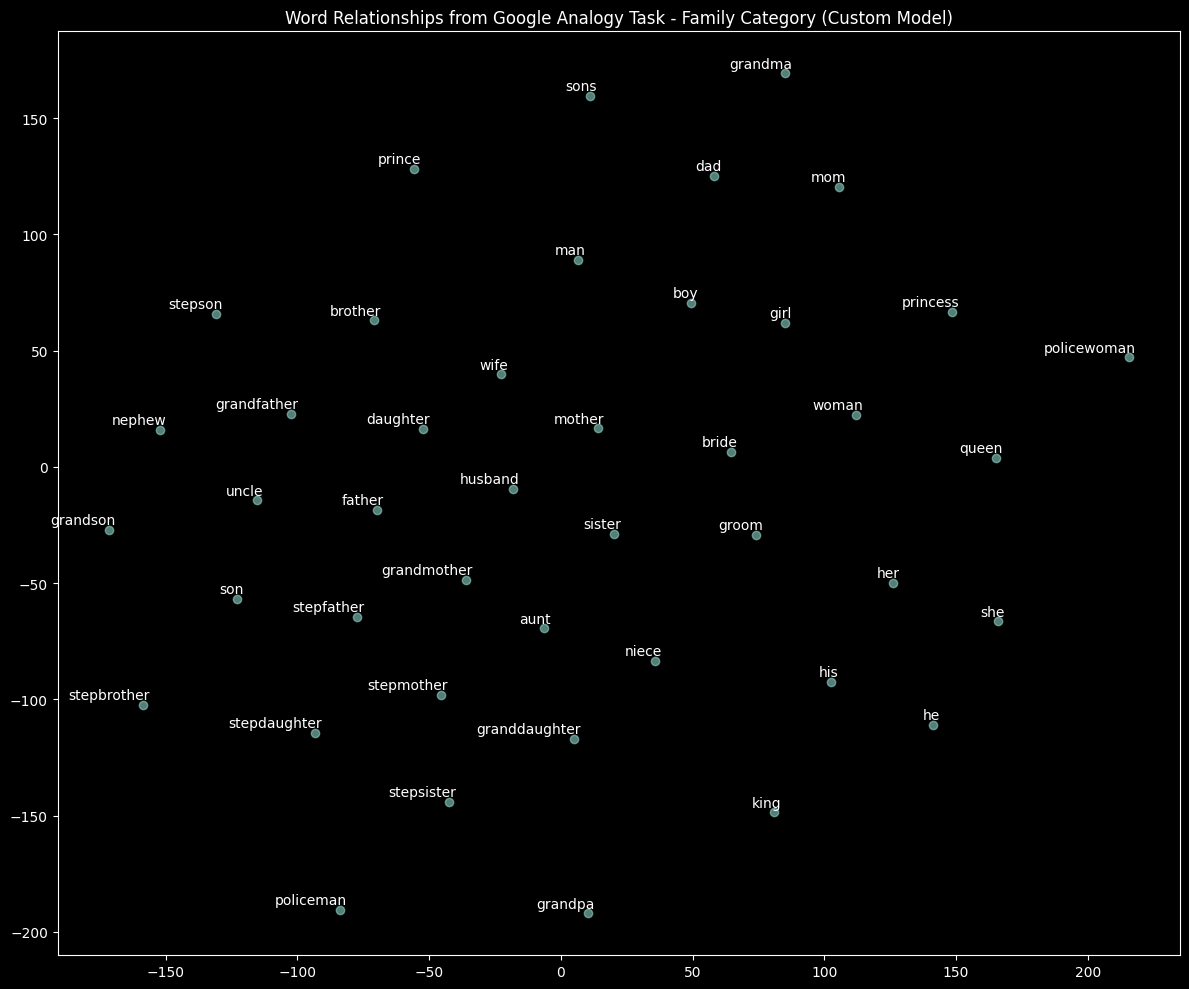

In [6]:
# Collect words from Google Analogy dataset
SUB_CATEGORY = ": family"

# TODO7: Plot t-SNE for the words in the SUB_CATEGORY `: family`

# 確保加載自訓練模型
from gensim.models import KeyedVectors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# 自訓練模型
try:
    custom_model = KeyedVectors.load("wiki_word2vec.kv")
    print(f"成功載入自訓練詞向量模型，詞彙量: {len(custom_model.key_to_index)}")
except FileNotFoundError:
    print("警告: 找不到自訓練模型文件，請確保您已經執行了TODO5的代碼。")

# 過濾出family子類別的資料
family_data = data[data['SubCategory'] == SUB_CATEGORY]

# 提取family類別中的所有唯一詞彙
family_words = set()
for analogy in family_data['Question']:
    words = analogy.split()
    if len(words) == 4:
        family_words.update(words)

print(f"family類別中的唯一詞彙數量: {len(family_words)}")

# 獲取這些詞彙在自訓練模型中的向量表示
family_word_vectors = []
family_word_labels = []
missing_words = []
for word in family_words:
    if word in custom_model.key_to_index:  # 確認詞彙存在於模型中
        family_word_vectors.append(custom_model[word])
        family_word_labels.append(word)
    else:
        missing_words.append(word)

print(f"具有向量表示的詞彙數量: {len(family_word_vectors)}")
if missing_words:
    print(f"在自訓練模型中找不到的詞彙: {', '.join(missing_words)}")

# 將列表轉換為NumPy數組
family_word_vectors = np.array(family_word_vectors)

# 確保有足夠的詞彙做t-SNE
if len(family_word_vectors) >= 2:
    # 使用t-SNE將高維向量降至2維
    tsne = TSNE(n_components=2, perplexity=min(30, len(family_word_vectors)-1), 
                learning_rate=200, random_state=42)
    word_vectors_2d = tsne.fit_transform(family_word_vectors)

    plt.figure(figsize=(12, 10))
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.6)

    for i, word in enumerate(family_word_labels):
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom',fontsize=10)

    # 調整圖形
    plt.title("Word Relationships from Google Analogy Task - Family Category (Custom Model)")
    #plt.grid(False)  
    plt.tight_layout()  #優化佈局
    plt.show()
else:
    print("錯誤: 詞彙數量不足，無法進行t-SNE降維。")

In [9]:
def evaluate_analogy(model, analogy_file="questions-words.txt"):
    """
    讀取 analogy 檔案，並根據每個類別統計：
      - 類別下的總題數
      - OOV 題數（任一詞不在詞彙表中）
      - 若所有詞都在詞彙表中，則進行預測並統計正確數
    回傳一個字典，每個類別包含上述統計資料。
    """
    current_category = None
    results = {}  # 存放每個類別的統計數據

    with open(analogy_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # 當行以 ':' 開頭時，代表新的子類別標籤
            if line.startswith(":"):
                current_category = line[2:].strip()  # 例如 ": family" -> "family"
                results[current_category] = {"total": 0, "oov": 0, "evaluated": 0, "correct": 0}
            else:
                words = line.split()
                if len(words) != 4:
                    continue
                results[current_category]["total"] += 1

                # 判斷是否有任一詞不在模型詞彙中
                if any(word not in model.key_to_index for word in words):
                    results[current_category]["oov"] += 1
                    continue

                results[current_category]["evaluated"] += 1
                try:
                    # 根據公式：B - A + C
                    prediction = model.most_similar(positive=[words[1], words[2]], negative=[words[0]], topn=1)
                    predicted_word = prediction[0][0]
                    if predicted_word == words[3]:
                        results[current_category]["correct"] += 1
                except Exception as e:
                    pass

    return results

# 載入 KeyedVectors
from gensim.models import KeyedVectors
model = KeyedVectors.load(r"D:\envAI01\nlp_hw1\wiki_word2vec.kv")

results = evaluate_analogy(model, analogy_file="questions-words.txt")

# 印出每個類別的統計數據
for category, data in results.items():
    total = data["total"]
    oov = data["oov"]
    evaluated = data["evaluated"]
    correct = data["correct"]
    print(f"Category: {category}")
    print(f"  Total analogies: {total}")
    print(f"  OOV analogies: {oov} ({oov/total*100:.2f}%)")
    if evaluated > 0:
        print(f"  Evaluated analogies (in-vocabulary): {evaluated}")
        print(f"  Correct predictions: {correct} ({correct/evaluated*100:.2f}%)")
    print("")

Category: capital-common-countries
  Total analogies: 506
  OOV analogies: 506 (100.00%)

Category: capital-world
  Total analogies: 4524
  OOV analogies: 4524 (100.00%)

Category: currency
  Total analogies: 866
  OOV analogies: 866 (100.00%)

Category: city-in-state
  Total analogies: 2467
  OOV analogies: 2467 (100.00%)

Category: family
  Total analogies: 506
  OOV analogies: 86 (17.00%)
  Evaluated analogies (in-vocabulary): 420
  Correct predictions: 385 (91.67%)

Category: gram1-adjective-to-adverb
  Total analogies: 992
  OOV analogies: 122 (12.30%)
  Evaluated analogies (in-vocabulary): 870
  Correct predictions: 297 (34.14%)

Category: gram2-opposite
  Total analogies: 812
  OOV analogies: 0 (0.00%)
  Evaluated analogies (in-vocabulary): 812
  Correct predictions: 180 (22.17%)

Category: gram3-comparative
  Total analogies: 1332
  OOV analogies: 0 (0.00%)
  Evaluated analogies (in-vocabulary): 1332
  Correct predictions: 1067 (80.11%)

Category: gram4-superlative
  Total anal

In [1]:
!pip3 freeze > requirements.txt